<a href="https://colab.research.google.com/github/km-kwon/MLteamproject/blob/main/baseline_review_ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Modules

### konlpy import script (접어놓고 쓰세용)

In [2]:
#from https://teddylee777.github.io/colab/colab-mecab

!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash 

#####위 스크립트는 konlpy 사용하기 위해서 comment 처리 해제 후에 꼭 실행시켜주세요#####

--2022-11-25 09:59:11--  https://www.dropbox.com/s/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz [following]
--2022-11-25 09:59:12--  https://www.dropbox.com/s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca580581dedf28db3c15bbd13f0.dl.dropboxusercontent.com/cd/0/get/Bxaei8PhlWruWdxEYkuoQHKqT7G-mX17qom_7va7uSJa_AK9SQPjTO9VQesoP1zPxr-YJ2kapqQ2t3262NWvR77GboTUPbu-U_e0zEotdPr9JDnkoKgxVOc9OZfEUis2TDTKNoxkzs5QRsuw5G1QvMHimbr6lTEDLaox8Ich7XRFJP8167D6f3Nu1bK9A-JLs8k/file?dl=1# [following]
--2022-11-25 09:59:12--  https://uca580581dedf28db3c15bbd13f0.dl.dropboxusercontent.com/cd/0/get/Bxaei8PhlWr

### Import Modules

In [ ]:
#토크나이저 비교 글 https://mr-doosun.tistory.com/22

from konlpy.tag import Okt, Mecab

Okt = Okt()

Okt.morphs('한글 형태소 분석기(오케이티)로 테스트를 해보았습니다. 정상 설치 및 동작이 잘 됩니다.')

In [4]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Embedding, LSTM, GRU, Bidirectional, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## Data Load & Preprocessing


### Load Data

In [5]:
my_path = '/content' #colab 업로드 기준, 자유롭게 변경해주세용.
project_path = '/content/sharing'

def load_data(dir, file_name):
  df = pd.read_csv(os.path.join(dir,file_name), sep=",",encoding ='cp949')
  return df

train_raw = load_data(my_path, 'DATA2.csv')

#학습에 사용할 데이터
train_df = train_raw.copy()
train_df = train_df[['reple','star_score']]
display(train_df.head(10))

,reple,star_score
0,처음부터 끝까지 스트레스 없이 잘봤습니다. 그런데 빨간머리 여배우에게서 설리씨가 보...,10
1,거석이형님 매력미쳐버리네,10
2,생각한만큼 웃겼고ㅋㅋ 많이 슬프기도ㅠㅠ,10
3,좋아하는 배우들이 많이 나와서 더 좋았던 영화! 오랜만에 마음 따뜻해진다!,10
4,꿀잼이었습니다 ㅋㅋㅋㅋ 마블리의 캐릭터는 독보적이네요 다른 배우분들도 기존 연기와 ...,10
5,배우들 케미 미쳤다 ㅋㅋㅋㅋ 마동석은 이런 정통 코미디에도 막강하네요 ㅋㅋㅋ,10
6,"마동석의 클래스, 박정민의 한방, 정해인의 재발견",10
7,사실 큰 기대 안하고 보게 된건데 너무 웃겼음. 중간에 빵빵 터지는 요소들이 많았고...,10
8,"인생이힘들어도,사람속에서 살아야함을",10
9,적당한 재미와 적당한 감동이 부릉부릉~!연말에 웃으면서 가볍게 볼 수 있음.,10


,star_score,count
0,1,4020
1,2,2109
2,3,2590
3,4,2423
4,5,4451


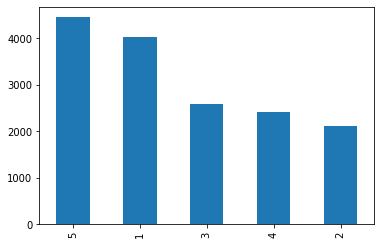

In [6]:
###########################################################################
#                     이 셀은 한번만 실행해야 합니당                      #
###########################################################################

# star_score 점수 1~5 사이의 값으로 변환
def transform_score(score):
  return {
      10 : 5,
      9 : 5,
      8 : 4,
      7 : 4,
      6 : 3,
      5 : 3,
      4 : 2,
      3 : 2,
      2 : 1,
      1 : 1,   
  }.get(score, -1)

# print('#==== 각 column 별 결측값 확인 ====#')  #제거가 잘 안되는듯?? 주석 풀면 에러남#
# print(train_df.isna().sum()) 

# #한글과 공백을 제외하고 모두 제거
# train_df['reple'] = train_df['reple'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

# # 제거한 후 공백이 되어버린 데이터를 empty 값으로 지정
# train_df['reple'] = train_df['reple'].str.replace('^ +', "") 
# train_df['reple'].replace('', np.nan, inplace=True)

# # 결측값 유무 확인 후, 결측값 제거
# print('\n#==== 한글과 공백을 제외하고 모두 제거한 후, 각 column 별 결측값 확인 ====#')
# print(train_df.isnull().sum())

# train_df =train_df.dropna(how = 'any')
# print('전처리된 데이터 샘플 수 확인:', len(train_df), '\n')

# # document 열과 label 열의 중복을 제외한 값의 개수
# print('\n#==== 각 column 별 중복되지 않은 값의 개수 ====#')
# print("reple:", train_df['reple'].nunique())
# print("star_score:", train_df['star_score'].nunique())

# #reple 열의 중복된 데이터 제거
# train_df.drop_duplicates(subset=['reple'], inplace=True)

# #데이터에 결측값이 있는지 확인
# print('중복값 제거후, 각 column 별 중복된 값의 개수:', train_df.isnull().values.sum(), '\n')

#star_score 점수 변환
train_df['star_score'] = train_df['star_score'].apply(lambda train_df: transform_score(train_df))
train_df['star_score'].value_counts().plot(kind = 'bar')
train_df.groupby('star_score').size().reset_index(name = 'count')

### Split data into Train & Test

In [7]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size= 0.3, random_state= 42)

for train_index, test_index in splitter.split(train_df,train_df['star_score']):
  train_data = train_df.loc[train_index]
  test_data = train_df.loc[test_index]

# 인덱스 재정렬
train_data.index = pd.RangeIndex(len(train_data.index))
test_data.index = pd.RangeIndex(len(test_data.index))

print('=============================================================================================')
print('#========================== 나눈 DataFrame의 크기,분포 확인 ===============================#')
print('=============================================================================================')

print(f"Training Data Size : {len(train_data)}")
display(train_data.head(10))
print(f"Testing Data Size : {len(test_data)}")
display(test_data.head(10))
print('\n')


#========================== 나눈 DataFrame의 크기,분포 확인 ===============================#
Training Data Size : 10915


,reple,star_score
0,배우들의 눈물은 영화가 망해서 나오는 눈물입니다.,1
1,내가 어른이 된거 같으면서도 아직 철없는 애 인거같은 두가지의 미묘한 감정,4
2,"마동석, 박정민 배우의 연기력이 돋보이는 영화,마동석을 잘 활용 하였고 박정민 배우...",4
3,"극 초반 오달수의 물과 기름같이 따로 노는 대사 내용, 1차원적인 꼬임 없는 그냥 ...",1
4,전편에 비해 훨씬 떨어지는 긴장감과 어설픈 연출 및 연기,3
5,오달수형때문에 몇번웃었다 . 그게끝이다 그냥,1
6,즐거운 영화 한표,3
7,진짜 오늘 다시 보는데 잼있네요 진짜 강동원 짱 멋있네 연기도 그당시로선 잘했네 로...,5
8,"레옹 마틸도 팬이고 마블스튜디오 광팬인데,정말 이번영화는 심각하게 재미가 없네요.",1
9,적당한 코믹과 감동이 잘 버무려졌다,5


Testing Data Size : 4678


,reple,star_score
0,재미있는데 스토리가 아예없는수준....,3
1,진짜노잼..뭔스토리인지도모르겠고심지어 재미도 그냥어이가없어서웃음나옴..중간에잠들었네...,1
2,스토리가 없음. 마동석 연기하나로 순간 몇번 웃음이 터져서 그걸로 이 영화를 택한 ...,3
3,항공관련 재난 영화이면 항공관련 고증을 신경써주었으면 한다. 영화적 허용이라도 그 ...,2
4,스토리가 아쉽긴 한데 킬링타임용으론 괜찮아요.,4
5,김성균씨랑 차승원씨 연기 너무 어색함ㅠㅠㅠ 엑시트처럼 빵빵 웃기는것도 아니고 타워나...,3
6,배우분들이 연기를 진짜 잘하셨다,5
7,"솔직히 1편,2편은 조선 명탐정이라는 내용에 그나마 잘맞았는데 이번편은 너무 판타지...",2
8,결말이 아쉬워 10점만점을 주진 못함. ㅈㄴ웃긴 거석이 형을 보고싶다면 강추~!!!,5
9,가볍게 보긴 좋은 듯 배우들 연기도 좋고 딱 전형적인 한국영화,3


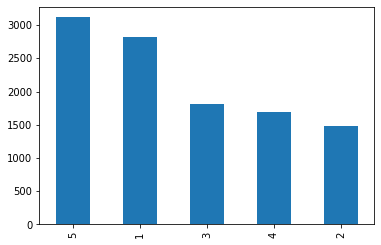

In [8]:
train_data['star_score'].value_counts().plot(kind = 'bar')

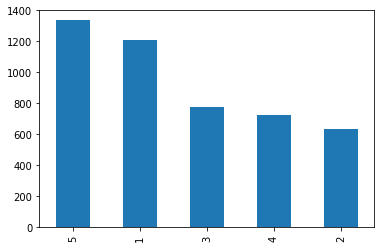

In [9]:
test_data['star_score'].value_counts().plot(kind = 'bar')

### Label One-hot Encoding & Review Tokenizing

In [10]:
#split labels
y_train = train_data[['star_score']]
y_test = test_data[['star_score']]

# one_hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [11]:
##from https://wikidocs.net/44249

tokenized_train = []
tokenized_test = []

stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','.','..','...',',','만','이다','을']
# 불용어(감정 분석에 영향 없는 용어) 정의, 이외에도 여러가지 추가적으로 정의할 수 있음.  이것도 정확도에 영향을 끼칠 수 있을 것 같아요 아마/./.?

for sentence in tqdm(train_data['reple']):
     tokenized_sentence = Okt.morphs(sentence, stem=True) # 토큰화
     stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
     tokenized_train.append(stopwords_removed_sentence)

for sentence in tqdm(test_data['reple']):
     tokenized_sentence = Okt.morphs(sentence, stem=True) # 토큰화
     stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
     tokenized_test.append(stopwords_removed_sentence)

100%|██████████| 4678/4678 [00:14<00:00, 319.39it/s]


In [12]:
# 등장 빈도 확인
def check_frequency(num, tokenizer):
  threshold = num # 등장 빈도가 threshold보다 낮으면 희귀 단어로 분류
  total_cnt = len(tokenizer.word_index) # tokenizing된 모든 단어의 개수
  rare_cnt = 0 # 희귀 단어 개수
  total_freq = 0 # 입력 데이터의 전체 단어 빈도
  rare_freq = 0 # 희귀 단어 등장 빈도 합
    
  for word, freq in tokenizer.word_counts.items():
    total_freq += freq # 전체 빈도
    if (freq < threshold) : # 전체 등장 빈도가 threshold보다 낮으면
      rare_cnt += 1 # 희귀 단어로 간주
      rare_freq += freq # 희귀 단어 등장 빈도 업데이트
     
  print(f'최소 등장 빈도 : {threshold-1}')
  print(f'어휘 집합 크기 : {total_cnt}')
  print(f'희귀 단어 수 :  {rare_cnt}')
  print(f'어휘 집합에서 희귀 단어의 비중 : {(rare_cnt/total_cnt)*100}')
  print(f'전체 단어 빈도에서 희귀 단어 빈도 : {(rare_freq/total_freq)*100}')
     
  return total_cnt, rare_cnt

# check frequency
test_tokenizer = Tokenizer()
test_tokenizer.fit_on_texts(tokenized_train)

for THRESHOLD in range(1, 10):
    check_frequency(THRESHOLD+1, test_tokenizer)
    print("="*70)

최소 등장 빈도 : 1
어휘 집합 크기 : 10286
희귀 단어 수 :  4808
어휘 집합에서 희귀 단어의 비중 : 46.743146023721565
전체 단어 빈도에서 희귀 단어 빈도 : 3.2832783616386343
최소 등장 빈도 : 2
어휘 집합 크기 : 10286
희귀 단어 수 :  6230
어휘 집합에서 희귀 단어의 비중 : 60.56776200661093
전체 단어 빈도에서 희귀 단어 빈도 : 5.225383948265148
최소 등장 빈도 : 3
어휘 집합 크기 : 10286
희귀 단어 수 :  6962
어휘 집합에서 희귀 단어의 비중 : 67.68423099358351
전체 단어 빈도에서 희귀 단어 빈도 : 6.7249844645210635
최소 등장 빈도 : 4
어휘 집합 크기 : 10286
희귀 단어 수 :  7414
어휘 집합에서 희귀 단어의 비중 : 72.07855337351741
전체 단어 빈도에서 희귀 단어 빈도 : 7.959628241110633
최소 등장 빈도 : 5
어휘 집합 크기 : 10286
희귀 단어 수 :  7748
어휘 집합에서 희귀 단어의 비중 : 75.32568539762784
전체 단어 빈도에서 희귀 단어 빈도 : 9.100034826787946
최소 등장 빈도 : 6
어휘 집합 크기 : 10286
희귀 단어 수 :  7998
어휘 집합에서 희귀 단어의 비중 : 77.75617343962668
전체 단어 빈도에서 희귀 단어 빈도 : 10.124352119312478
최소 등장 빈도 : 7
어휘 집합 크기 : 10286
희귀 단어 수 :  8192
어휘 집합에서 희귀 단어의 비중 : 79.64223216021777
전체 단어 빈도에서 희귀 단어 빈도 : 11.051700708144688
최소 등장 빈도 : 8
어휘 집합 크기 : 10286
희귀 단어 수 :  8352
어휘 집합에서 희귀 단어의 비중 : 81.19774450709703
전체 단어 빈도에서 희귀 단어 빈도 : 11.925784797765623
최소

In [13]:
# get vocab size
threshold = 2 # 2회 미만이  가장 적당? hyperparameter?
total_cnt, rare_cnt = check_frequency(threshold, test_tokenizer)
vocab_size = total_cnt - rare_cnt + 1

# tokenizer
print("################# Dictionary ###################")
myTokenizer = Tokenizer(vocab_size)
myTokenizer.fit_on_texts(tokenized_train)
print(myTokenizer.index_word)

# encode to integer sequences
tokenized_train = myTokenizer.texts_to_sequences(tokenized_train)
tokenized_test = myTokenizer.texts_to_sequences(tokenized_test)

# check data
print("################# 정수 인코딩 ###################")
print(tokenized_train[0])
print(tokenized_test[0])

최소 등장 빈도 : 1
어휘 집합 크기 : 10286
희귀 단어 수 :  4808
어휘 집합에서 희귀 단어의 비중 : 46.743146023721565
전체 단어 빈도에서 희귀 단어 빈도 : 3.2832783616386343
################# Dictionary ###################
{1: '영화', 2: '보다', 3: '없다', 4: '너무', 5: '좋다', 6: '있다', 7: '재밌다', 8: '연기', 9: '배우', 10: '스토리', 11: '진짜', 12: '다', 13: '같다', 14: '로', 15: '?', 16: '그냥', 17: '되다', 18: '적', 19: '감동', 20: '않다', 21: '아니다', 22: '인', 23: '나오다', 24: '생각', 25: '마동석', 26: '점', 27: '에서', 28: '안', 29: '재미', 30: '!', 31: '정말', 32: '만들다', 33: '소재', 34: '평점', 35: '그', 36: '느낌', 37: '것', 38: '볼', 39: '아쉽다', 40: '게', 41: '진부하다', 42: '아깝다', 43: '자다', 44: '고', 45: '가다', 46: '더', 47: '지겹다', 48: '~', 49: '내용', 50: '모르다', 51: '돈', 52: '....', 53: '말', 54: '왜', 55: 'ㅋㅋ', 56: '내', 57: '재미있다', 58: '싶다', 59: '나', 60: '웃기다', 61: '보고', 62: '거', 63: '하고', 64: '성', 65: '웃다', 66: '시간', 67: '못', 68: '요', 69: '사람', 70: '결말', 71: '1', 72: '들다', 73: '강동원', 74: '까지', 75: '많다', 76: '감독', 77: '그렇다', 78: '중간', 79: '보기', 80: '정도', 81: '주다', 82: '개연', 83: '중', 84: '때', 8

In [14]:
# get empty indices
empty_train = [idx for idx, sent in enumerate(tokenized_train) if len(sent) < 1]
empty_test = [idx for idx, sent in enumerate(tokenized_test) if len(sent) < 1]
print(f"삭제된 train data index : {len(empty_train)}개, {empty_train}")
print(f"삭제된 test data index : {len(empty_test)}개, {empty_test}")

# check empty data
display(train_data[157:160])
display(test_data[130:133])

,reple,star_score
157,쫄깃하고 반전있는 스토리전개 흥미롭게 봤어요,4
158,초등학생 2명과 같이 봤는데 엄청 웃었네요. 중간에 울었다가 또 웃었다가 ㅋ저희들은...,4
159,진짜..이건 마지막끝까지 보고 난후에 지림;;;소름 ...명작이다,5


,reple,star_score
130,"재밌고.. 재밌고,, 웃기고.. 킬링타임",4
131,태성이내꺼♥♡하트뿅뿅>_<너므 조하 ㅋ>,5
132,강동원진짜풋풋하고잘생겼다..유치하긴한데 지금봐도 울면서봤음..강동원의강동원에의한강동...,5


In [15]:
# delete empty data
# train set
X_train = np.delete(tokenized_train, empty_train, axis = 0)
y_train = np.delete(y_train, empty_train, axis = 0)

# test set
X_test = np.delete(tokenized_test, empty_test, axis = 0)
y_test = np.delete(y_test, empty_test, axis = 0)

################# 정수 인코딩 ###################
[9, 315, 1, 573, 23, 315]
[57, 10, 1509, 3, 228, 52]
삭제된 train data index : 13개, [266, 1828, 3124, 4357, 4605, 5019, 5710, 6646, 8387, 9051, 9699, 10736, 10737]
삭제된 test data index : 12개, [303, 1209, 1672, 1716, 2444, 2932, 2994, 3389, 3743, 3883, 4112, 4467]


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


### Padding

리뷰의 최대 길이 : 47
리뷰의 평균 길이 : 12.991286002568335


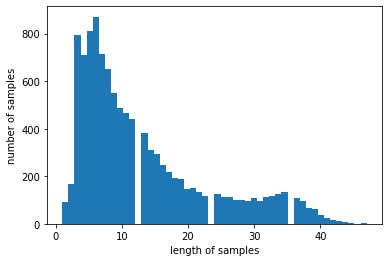

In [16]:
import matplotlib.pyplot as plt

print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [17]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [18]:
max_len = 35 #hyperparameter
below_threshold_len(max_len, X_train) 

전체 샘플 중 길이가 35 이하인 샘플의 비율: 96.02825169693634


In [19]:
#LSTM 모델에 넣기 위해 input의의 입력 길이를 같은 사이즈로 맞추는 작업, 여기서는 35로 패딩해서 맞췄습니다

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_len)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_len)

In [20]:
# 데이터 확인
print(X_train[103])
print(X_test[54])

[   0    0    0    0    0    0    0    0    0    0    7    2 1232  102
  281  576  133  178  713    1    2  714   27  972    6   37  402   24
 1940   68   43    2  197    1   21]
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0 412  18 205 661 933 490  19   6]


In [21]:
# check data dimension
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(10902, 35)
(10902, 6)
(4666, 35)
(4666, 6)


## Define LSTM Model

In [22]:
def my_LSTM(embed_dim, n_vocab, max_len, bidirectional, out_dim, layers, optim, dropout):
  with tf.device('/gpu:0'):
      model = Sequential()
      model.add(Embedding(n_vocab, embed_dim, input_length = max_len))
      for _ in range(layers): #layer만큼 LSTM 층 만들기.
        if not bidirectional:
          # 단방향 LSTM
          model.add(LSTM(out_dim)) 
        else: # 양방향 LSTM
          model.add(Bidirectional(LSTM(out_dim)))

      model.add(Dense(out_dim, activation='relu'))#FC
      model.add(Dropout(0.2))
      model.add(Dense(6, activation = 'softmax')) 

      # 모델 컴파일
      model.compile(optimizer = optim,
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
      # 모델 확인
      print(model.summary())

  return model

## Train & Validate & Test with fine-tuning

**************** 참고 자료 *******************

https://www.dacon.io/competitions/official/235670/codeshare/1893?page=1&dtype=recent

https://teddylee777.github.io/tensorflow/lstm-layer, for additional hyperparameters

In [23]:
#   _    ___     _______  ______ _____  _____        _____            __  __ _______ ______ _____   _____ 
#  | |  | \ \   / /  __ \|  ____|  __ \|  __ \ /\   |  __ \     /\   |  \/  |__   __|  ____|  __ \ / ____|
#  | |__| |\ \_/ /| |__) | |__  | |__) | |__) /  \  | |__) |   /  \  | \  / |  | |  | |__  | |__) | (___  
#  |  __  | \   / |  ___/|  __| |  _  /|  ___/ /\ \ |  _  /   / /\ \ | |\/| |  | |  |  __| |  _  / \___ \ 
#  | |  | |  | |  | |    | |____| | \ \| |  / ____ \| | \ \  / ____ \| |  | |  | |  | |____| | \ \ ____) |
#  |_|  |_|  |_|  |_|    |______|_|  \_\_| /_/    \_\_|  \_\/_/    \_\_|  |_|  |_|  |______|_|  \_\_____/  #일단 제가 생각해본본건 이정도인데.. 
                                                                                                           #이정도만 있는 게 맞는지는 모르겠습니다..
                                                                                                        
                                                                                                        
# ====== Embedding ========= #

embed_dim = 100
n_vocab = vocab_size # 단어장의 길이(defined in Tokenizing)
max_sequence = max_len # 리뷰 데이터에서의 최대 길이(defined in Padding)

# ====== Model Capacity ===== #

out_dim = 128
layers = 1
bidirectional = True

# ====== Regularization ======= #

L2 = 0.001
dropout = 0.2
use_bn = False #batch normalization 

# ====== Optimizer & Training ====== #

optim = 'adam' #'RMSprop' #SGD, RMSprop, ADAM...
lr = 0.0001 #learning rate for optim
epoch = 20
val_portion = 0.25

# ==== Early Stopping ======= #
ck = ModelCheckpoint(filepath=my_path, monitor='val_loss', verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_loss', patience=3) #3번 참는다.


model = my_LSTM(embed_dim, n_vocab, max_len, bidirectional, out_dim, layers, optim, dropout)

# ==== Train and Validation ==== #
history = model.fit(X_train, y_train,
                    epochs=epoch,
                    callbacks = [ck, es],
                    validation_split = val_portion)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 35, 100)           547900    
                                                                 
 bidirectional (Bidirectiona  (None, 256)              234496    
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                                 
Total params: 816,066
Trainable params: 816,066
Non-trainable params: 0
__________________________________________________

256/256 [==============================] - 36s 116ms/step - loss: 1.3347 - accuracy: 0.4546 - val_loss: 1.1288 - val_accuracy: 0.5477
Epoch 2/20
250/256 [============================>.] - ETA: 0s - loss: 0.9731 - accuracy: 0.6164
Epoch 2: val_loss improved from 1.12882 to 1.11122, saving model to /content


256/256 [==============================] - 17s 65ms/step - loss: 0.9744 - accuracy: 0.6162 - val_loss: 1.1112 - val_accuracy: 0.5613
Epoch 3/20
253/256 [============================>.] - ETA: 0s - loss: 0.7920 - accuracy: 0.6943
Epoch 3: val_loss did not improve from 1.11122
256/256 [==============================] - 2s 9ms/step - loss: 0.7930 - accuracy: 0.6935 - val_loss: 1.1297 - val_accuracy: 0.5642
Epoch 4/20
255/256 [============================>.] - ETA: 0s - loss: 0.6619 - accuracy: 0.7485
Epoch 4: val_loss did not improve from 1.11122
256/256 [==============================] - 2s 10ms/step - loss: 0.6623 - accuracy: 0.7483 - val_loss: 1.2971 - val_accuracy: 0.5429
Epoch 5/20
255/256 [============================>.] - ETA: 0s - loss: 0.5529 - accuracy: 0.7949
Epoch 5: val_loss did not improve from 1.11122
256/256 [==============================] - 2s 10ms/step - loss: 0.5528 - accuracy: 0.7948 - val_loss: 1.4179 - val_accuracy: 0.5242


In [24]:
with tf.device('/gpu:0'): 
  print("Test accuracy : %.4f" % (model.evaluate(X_test, y_test))[1])

146/146 [==============================] - 1s 4ms/step - loss: 1.4379 - accuracy: 0.5242
Test accuracy : 0.5242


## Predict star score 
(hyperparameter 모두 설정되고 SNS 크롤링 데이터 보내주시면 추후 추가하겠습니다.)